In [1]:
from PIL import Image
import numpy as np


images = []
for i in range(6):
    img = Image.open(f"dataset/{i+1}.png").convert("RGB")
    img = img.resize((56, 56))
    img = (np.array(img).astype(np.float32) - 127.5) / 127.5
    images.append(img)

train_images = np.array(images)

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, losses, optimizers
from keras import Sequential, Model
import numpy as np


class GAN(Model):
    def __init__(self, **kwargs):
        super(GAN, self).__init__(**kwargs)

        self.generator = Sequential(
            [
                layers.Dense(128 * 14 * 14, activation="relu", input_dim=(100)),
                layers.Reshape((14, 14, 128)),
                layers.UpSampling2D(),
                layers.Conv2D(128, kernel_size=3, padding="same"),
                layers.BatchNormalization(momentum=0.8),
                layers.Activation("relu"),
                layers.UpSampling2D(),
                layers.Conv2D(64, kernel_size=3, padding="same"),
                layers.BatchNormalization(momentum=0.8),
                layers.Activation("relu"),
                layers.Conv2D(3, kernel_size=3, padding="same"),
                layers.Activation("tanh"),
            ],
            name="Generator",
        )

        assert self.generator.output_shape == (None, 56, 56, 3)

        self.discriminator = Sequential(
            [
                layers.Conv2D(
                    32,
                    kernel_size=3,
                    strides=2,
                    input_shape=(56, 56, 3),
                    padding="same",
                ),
                layers.LeakyReLU(0.2),
                layers.Dropout(0.25),
                layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),
                layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
                layers.BatchNormalization(momentum=0.8),
                layers.LeakyReLU(0.2),
                layers.Dropout(0.25),
                layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
                layers.BatchNormalization(momentum=0.8),
                layers.LeakyReLU(0.2),
                layers.Dropout(0.25),
                layers.Conv2D(256, kernel_size=3, strides=1, padding="same"),
                layers.BatchNormalization(momentum=0.8),
                layers.LeakyReLU(0.2),
                layers.Dropout(0.25),
                layers.Flatten(),
                layers.Dense(1, activation="sigmoid"),
            ]
        )

        assert self.discriminator.output_shape == (None, 1)

        self.cross_entropy = losses.BinaryCrossentropy()
        self.discriminator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.generator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.generator_optimizer = optimizers.Adam()
        self.batch_size = 128

    def discriminator_loss(self, real, fake):
        real_loss = self.cross_entropy(tf.ones_like(real), real)
        fake_loss = self.cross_entropy(tf.zeros_like(fake), fake)
        return real_loss + fake_loss

    def generator_loss(self, fake):
        loss = self.cross_entropy(tf.ones_like(fake), fake)
        return loss

    def call(self):
        pass

    @tf.function
    def train_step(self, data):
        noise = tf.random.normal([self.batch_size, 100])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            images = self.generator(noise, training=True)

            real = self.discriminator(data, training=True)
            fake = self.discriminator(images, training=True)

            disc_loss = self.discriminator_loss(real, fake)
            gen_loss = self.generator_loss(fake)

        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        disc_gradients = disc_tape.gradient(
            disc_loss, self.discriminator.trainable_variables
        )

        self.generator_optimizer.apply_gradients(
            zip(gen_gradients, self.generator.trainable_variables)
        )
        self.discriminator_optimizer.apply_gradients(
            zip(disc_gradients, self.discriminator.trainable_variables)
        )

        return {"disc_loss": disc_loss, "gen_loss": gen_loss}

2024-09-17 11:22:50.227299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 11:22:50.313584: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 11:22:50.342665: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 11:22:50.510014: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 11:22:51.653434: W tensorflow/compiler/tf2

In [3]:
model = GAN()

model.compile()
model.fit(train_images, epochs=5000, batch_size=model.batch_size)

/home/smiilliin/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1726539775.196498   42863 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726539775.408517   42863 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726539775.408601   42863 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726539775.410486   42863 cuda_executor.cc:1001] co

Epoch 1/5000


/home/smiilliin/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1726539780.093418   43008 service.cc:146] XLA service 0x7f5f50003c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726539780.093726   43008 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-09-17 11:23:00.264768: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-17 11:23:00.725954: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1726539794.468982   43008 dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - disc_loss: 1.7122 - gen_loss: 1.5053
Epoch 2/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - disc_loss: 2.1212 - gen_loss: 0.7668
Epoch 3/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - disc_loss: 1.9366 - gen_loss: 0.4161
Epoch 4/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - disc_loss: 2.0913 - gen_loss: 0.3405
Epoch 5/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - disc_loss: 2.3360 - gen_loss: 0.4546
Epoch 6/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - disc_loss: 1.8382 - gen_loss: 0.7187
Epoch 7/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - disc_loss: 1.8201 - gen_loss: 0.6567
Epoch 8/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - disc_loss: 2.1854 - gen_loss: 0.8530
Epoch 9/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - disc_loss: 1.5698 - gen_loss: 0.6701
Epoch 10/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - disc_loss: 1.9145 - gen_loss: 0.6201
Epoch 11/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - disc_loss: 1.5660 - gen_loss: 0.5726
Epoch 12/5000
1/1 ━━

In [44]:
model.save("model.keras")

/home/smiilliin/.local/lib/python3.10/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [54]:
model = keras.models.load_model("model.keras", custom_objects={"GAN": GAN})

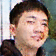

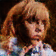

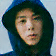

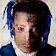

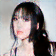

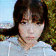

In [106]:
noise = tf.random.normal([6, 100])

images = np.array(model.generator(noise, training=False))

for img in images:
    img = Image.fromarray((img * 127.5 + 127.5).astype(np.uint8))
    display(img)

In [108]:
z = []
for i in range(5):
    z.append(
        np.array(
            [((1 - j) * noise[i] + j * noise[i + 1]) for j in np.arange(0, 1.1, 1 / 30)]
        )
    )

z = np.array(z)
z = z.reshape(z.shape[0] * z.shape[1], 100)

images2 = np.array(
    model.generator(
        z,
        training=False,
    )
)

images3 = [Image.fromarray((img * 127.5 + 127.5).astype(np.uint8)) for img in images2]

img = Image.new("RGBA", (56, 56), (0, 0, 0))
img.save("out.gif", save_all=True, append_images=images3, duration=(1000 // 30), loop=0)

In [110]:
noise = tf.random.normal([6, 10, 100])
z = []

for k in range(6):
    z_frames = []
    for i in range(9):
        z_frames.append(
            np.array(
                [
                    ((1 - j) * noise[k][i] + j * noise[k][i + 1])
                    for j in np.arange(0, 1.1, 1 / 30)
                ]
            )
        )
    z.append(z_frames)

z = np.array(z)
z = z.reshape(z.shape[0], z.shape[1] * z.shape[2], 100)


def to_images(images):
    result = []
    for img in images:
        result.append(Image.fromarray((img * 127.5 + 127.5).astype(np.uint8)))
    return result


images = [to_images(np.array(model.generator(img_z, training=False))) for img_z in z]
frames = []

for t in range(z.shape[1]):
    frame = np.zeros((56 * 2, 56 * 3, 3)).astype(np.uint8)
    for i in range(z.shape[0]):
        x = i % 3
        y = i // 3
        frame[y * 56 : (y + 1) * 56, x * 56 : (x + 1) * 56, :] = images[i][t]
    frame = Image.fromarray(frame)
    frames.append(frame)


img = Image.new("RGBA", (56 * 3, 56 * 2), (0, 0, 0))
img.save("out2.gif", save_all=True, append_images=frames, duration=(1000 // 30), loop=0)